Qiskit DemoDays, Dec 9, 2021
# Add transpiler passes in Aer for inserting instruction-dependent noises

https://github.com/Qiskit/qiskit-aer/pull/1391

Toshinari Itoko (Co-authored by Chris Wood)

## Summary

- Added two passes for inserting quantum errors into circuits: `LocalNoisePass` and `RelaxationNoisePass`
- Upgraded the default noise model implemented by `NoiseModel.from_backend` (and  `AerSimulator.from_backend`) to allow adding duration dependent relaxation error on delay instructions in a circuit using the `RelaxationNoisePass`.

=> Improve the accuracy of noisy simulation of circuits with delays such as T1 experiments.

New device noise model can add quantum errors to delay instructions in a circuit:

| Target operation: | Gate |　Measure　|　Delay　|
| :--- | :---: | :---: | :---: |
| Previous device noise model: | QuantumError | ReadoutError | *No error*  |
| New device noise model: | QuantumError | ReadoutError | *QuantumError* |

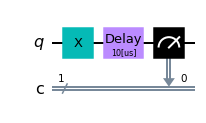

In [1]:
# a T1 circuit
from qiskit.circuit import QuantumCircuit
qc = QuantumCircuit(1, 1)
qc.x(0)
qc.delay(10, 0, unit="us")
qc.measure(0, 0)
qc.draw(output="mpl")

## Improved noisy simulation of T1 experiments

Use `ibmq_armonk` as a device backend

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device_backend = provider.get_backend('ibmq_armonk')
device_backend

<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

Print the latest reported T1 of qubit 0

In [3]:
from qiskit import transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit_experiments.library import T1 as T1Experiment

print(f"(Backend: {device_backend.name()}, Qubit: 0)")
print(f"Reported T1={device_backend.properties().t1(0) * 1e+3:.3f}[ms]")

(Backend: ibmq_armonk, Qubit: 0)
Reported T1=0.196[ms]


Create T1 experiment using `qiskit-experiments`

In [4]:
t1exp = T1Experiment(0, delays=list(range(1, 400, 10)), unit="us")

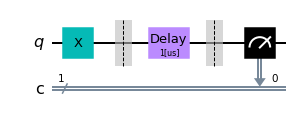

In [5]:
t1exp.circuits()[0].draw(output="mpl")  # the first T1 circuit

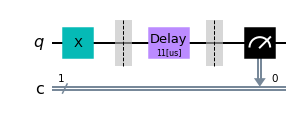

In [6]:
t1exp.circuits()[1].draw(output="mpl")  # the second T1 circuit

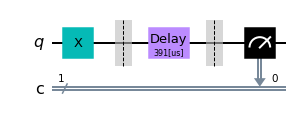

In [7]:
t1exp.circuits()[-1].draw(output="mpl")  # the last T1 circuit

Old noisy simulation with the default device noise model (before this PR)

Ref: Simulated T1 with old noise model=-1.49540348339054 ± nan s


/Users/itoko/envs/qiskit-aer-dev/lib/python3.8/site-packages/qiskit_experiments/curve_analysis/curve_fit.py:136: RuntimeWarning: invalid value encountered in sqrt
  popt_err = np.sqrt(np.diag(pcov))


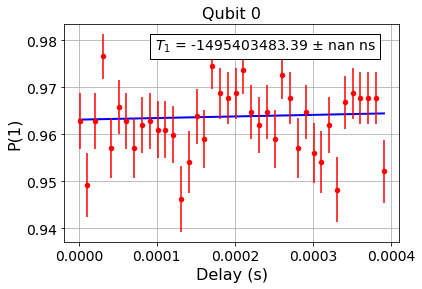

In [8]:
old_noise_model = NoiseModel.from_backend(device_backend)
old_noise_model._custom_noise_passes = []
old_sim = AerSimulator.from_backend(device_backend, noise_model=old_noise_model)
t1exp.set_transpile_options(scheduling_method="alap")
exp_data = t1exp.run(old_sim, seed_simulator=123).block_for_results()
result = exp_data.analysis_results()[0]
print(f"Ref: Simulated T1 with old noise model={result.value}")
display(exp_data.figure(0))

Noisy simulation with the default device noise model (after this PR)

Simulated T1=0.0001940676984308937 ± 6.430596264621892e-06 s
Ref: Reported T1=0.196[ms]


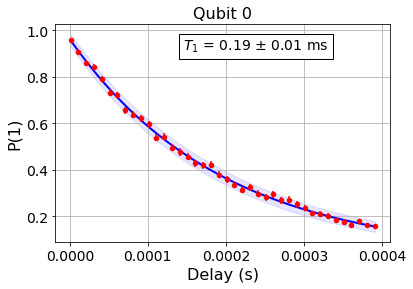

In [9]:
new_sim = AerSimulator.from_backend(device_backend)  # call NoiseModel.from_backend() behind the scene
t1exp.set_transpile_options(scheduling_method="alap")
exp_data = t1exp.run(new_sim, seed_simulator=123).block_for_results()
result = exp_data.analysis_results()[0]
print(f"Simulated T1={result.value}")
print(f"Ref: Reported T1={device_backend.properties().t1(0) * 1e+3:.3f}[ms]")
display(exp_data.figure(0))

### Current implementation is a bit hack
New noise model still stores a dictionary to represent how to add noises to gates or measres while it newly stores a pass manager to represent how to add noises to delays.

| | Target operation |　Who interpretes　|
| :--- | :---: | :---: |
| Dictionary: | Gate, Measure | Aer runs inserting noises on the fly |
| Pass manger: | Delay | Assembler embeds noises to circuits |

Let's see how the pass manager path works by T1 circuit example.

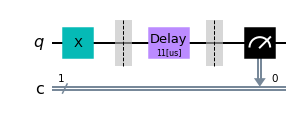

In [10]:
# original circuit
circ = t1exp.circuits()[1]
circ.draw(output="mpl")

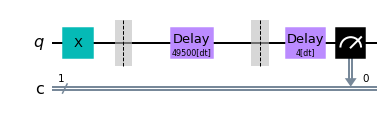

In [11]:
# transpiled circuit (scheduled circuit)
transpiled_circ = transpile(circ, device_backend, scheduling_method="alap")
transpiled_circ.draw(output="mpl")

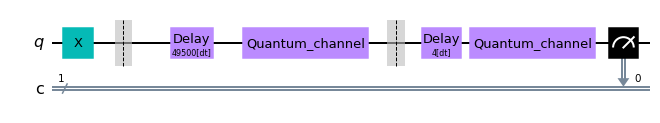

In [12]:
# noisy circuit
noise_model = NoiseModel.from_backend(device_backend)
noisy_circ = noise_model._pass_manager().run(transpiled_circ)  # within assembler
noisy_circ.draw(output="mpl")

## Summary
https://github.com/Qiskit/qiskit-aer/pull/1391

- Added two passes for inserting quantum errors into circuits: `LocalNoisePass` and `RelaxationNoisePass`
- Upgraded the default noise model implemented by `NoiseModel.from_backend` (and  `AerSimulator.from_backend`) to allow adding duration dependent relaxation error on delay instructions in a circuit using the `RelaxationNoisePass`.

=> Improve the noisy simulation of circuits with delays (e.g. T1 experiments) using the default device noise model.

In [13]:
noise_model = NoiseModel.from_backend(device_backend)
nmp = noise_model._pass_manager()
print(nmp.passes())

[{'passes': [<qiskit.providers.aer.noise.passes.relaxation_noise_pass.RelaxationNoisePass object at 0x14b96da60>], 'flow_controllers': {}}]


The pass is added within `NoiseModel.from_backend()`:
```
        if thermal_relaxation:
            delay_pass = RelaxationNoisePass(
                t1s=[properties.t1(q) for q in range(num_qubits)],
                t2s=[properties.t2(q) for q in range(num_qubits)],
                dt=dt,
                op_types=Delay,
                excited_state_populations=[_excited_population(freq=properties.frequency(q), temperature=temperature) for q in range(num_qubits)]
            )
            noise_model._custom_noise_passes.append(delay_pass)
```